<a href="https://colab.research.google.com/github/MatiasSiles/Sales-Optimization/blob/main/model_training_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import Dict, List, Tuple, Any, Optional, Union
from datetime import datetime, timedelta
import joblib
import json

from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV,
    StratifiedKFold, KFold, TimeSeriesSplit
)

from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder,
    OneHotEncoder, PolynomialFeatures
)

from sklearn.feature_selection import (
    SelectKBest, f_regression, f_classif, mutual_info_regression,
    mutual_info_classif, RFE, RFECV
)
from sklearn.ensemble import (
    RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor,
    GradientBoostingClassifier, AdaBoostRegressor, AdaBoostClassifier,
    ExtraTreesRegressor, ExtraTreesClassifier
)
from sklearn.linear_model import (
    LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet,
    BayesianRidge, HuberRegressor
)
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, FactorAnalysis, TruncatedSVD
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, silhouette_score
)

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import (
        Dense, Dropout, BatchNormalization, Input, LSTM, GRU,
        Conv1D, MaxPooling1D, Flatten, Embedding
    )
    from tensorflow.keras.optimizers import Adam, RMSprop, SGD
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.regularizers import l1, l2, l1_l2
    TENSORFLOW_AVAILABLE = True
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("TensorFlow not available")

# Advanced ML Libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False

# Statistical Libraries
from scipy import stats
from scipy.stats import (
    pearsonr, spearmanr, chi2_contingency, ttest_ind, mannwhitneyu,
    kruskal, shapiro, jarque_bera, anderson
)

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

from utils import (
    DataPreprocessor, StatisticalAnalyzer, MachineLearningOptimizer
)

warnings.filterwarnings('ignore')

In [20]:
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

np.random.seed(42)

# EDA for training models

In [4]:
# Data upload
df = pd.read_csv('/content/Sales_Business_Testing.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# Basic info of the dataset
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB") # converts actual memory usage from bytes to megabytes
print("\nFirst 5 rows:")
print(df.head())

print("\nData types:")
print(df.dtypes.value_counts())

print("\nMissing values:")
missing_values = df.isna().sum()
print(missing_values[missing_values > 0])

In [ ]:
# Data analysis
analyzer = StatisticalAnalyzer()
descriptive_stats = analyzer.descriptive_statistics(df)

print(descriptive_stats['numeric_summary'].round(2))

# CATEGORICAL VARIABLES SUMMARY, in this case, there isn't categorical variables, because this testing datast don't have
# for col, stats in descriptive_stats['categorical_summary'].items():
#     print(f"\n{col}:")
#     print(f"  Unique values: {stats['unique_values']}")
#     print(f"  Mode: {stats['mode']}")
#     print("  Top 5 values:")
#     print(stats['value_counts'].head())

# Distribution analysis
print()
descriptive_stats['skewness'].plot(kind='hist', label='skewness')
descriptive_stats['kurtosis'].plot(kind='hist', label='kurtosis')
plt.legend()
plt.show()

Why i choose these targets?:

*   total_amount: The aim is to predict the business's sales taking into account the variables that influence them, such as quantity sold, discounts prices, dates, etc
*   profit: anticipate profits, to know which products are profitable, improve decision-making and optimize prices.
*   satisfaction_score: Reduce churn, recommend products to each type
ofcustomer, improve customer experience
*   is_returned: reduce returns, optimize inventory, improve quality and products
*   order_frequency: customer retention, detect loyal customers, personalize marketing, improve cash flow
*   customer_lifetime_days: Seeking to ensure that customers remain active in the business for longer periods of time

In [ ]:
corr_matrix = analyzer.correlation_analysis(df, method='pearson')

# Find highly correlated features, this algorithm goes through the entire dataset by rows, comparing it with the threshold
def find_high_correlations(corr_matrix, threshold=0.8):
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)): # 91 columns
        for j in range(i+1, len(corr_matrix.columns)): # It is a loop where each iteration goes through all the columns while subtracting 1 column until reaching 0 columns
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append({
                    'Feature1': corr_matrix.columns[i], # add column 1 which participates in high correlations
                    'Feature2': corr_matrix.columns[j], # add column 2 which participates in high correlations
                    'Correlation': corr_matrix.iloc[i, j] # add the value
                })
    return pd.DataFrame(high_corr_pairs)

high_corr = find_high_correlations(corr_matrix, threshold=0.7)

if not high_corr.empty: # check whether or not high correlations were found
    print(f"\nHigh correlations found (>0.7):")
    print(high_corr)
else:
    print("\nNo high correlations found (>0.7)")

# Visualize correlation matrix, It's a confusing graph but I modified it to only show the correlations.
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # only shows half of the heat map
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Target variable correlations
TARGET_VARIABLES = ['total_amount', 'profit', 'satisfaction_score','is_returned', 'order_frequency', 'customer_lifetime_days']

for target in TARGET_VARIABLES:
    if target in df.columns:
        target_corr = corr_matrix[target].abs().sort_values(ascending=False) # find the 10 best correlations for each target
        print(f"\n{target} - Top 10 correlations:")
        print(target_corr.head(10))

i decided to do this because i think that can exist hidden relationships in important features for the training mode. If exist that relationship, probably can improve the model's performance. Whether a difference or relationship in the data is real or just a matter of luck

Significance:
*   p < 0.05 → is significant: probably is real the relationship
*   p > 0.05 → is not significant

In [ ]:
# It looks for relationships between numerical and categorical variables
categorical_cols = ['customer_gender', 'customer_segment', 'sales_channel', 'payment_method']
numerical_targets = ['total_amount', 'profit', 'satisfaction_score']

hypothesis_results = {}

for cat_col in categorical_cols:
    if cat_col in df.columns:
        for num_col in numerical_targets:
            if num_col in df.columns:
                print(f"\nTesting {cat_col} vs {num_col}:")

                test_result = analyzer.hypothesis_testing(
                    df, cat_col, num_col, test_type='auto'
                )

                hypothesis_results[f"{cat_col}_vs_{num_col}"] = test_result

                print(f"  Test used: {test_result['test_used']}")
                print(f"  P-value: {test_result['p_value']:.6f}")
                print(f"  Significant: {'Yes' if test_result['significant'] else 'No'}")

time series analysis

Analyzing sales over time...
Time series statistics:
  Mean: $206287.89
  Std: $24479.05
  Autocorrelation (lag=1): -0.070


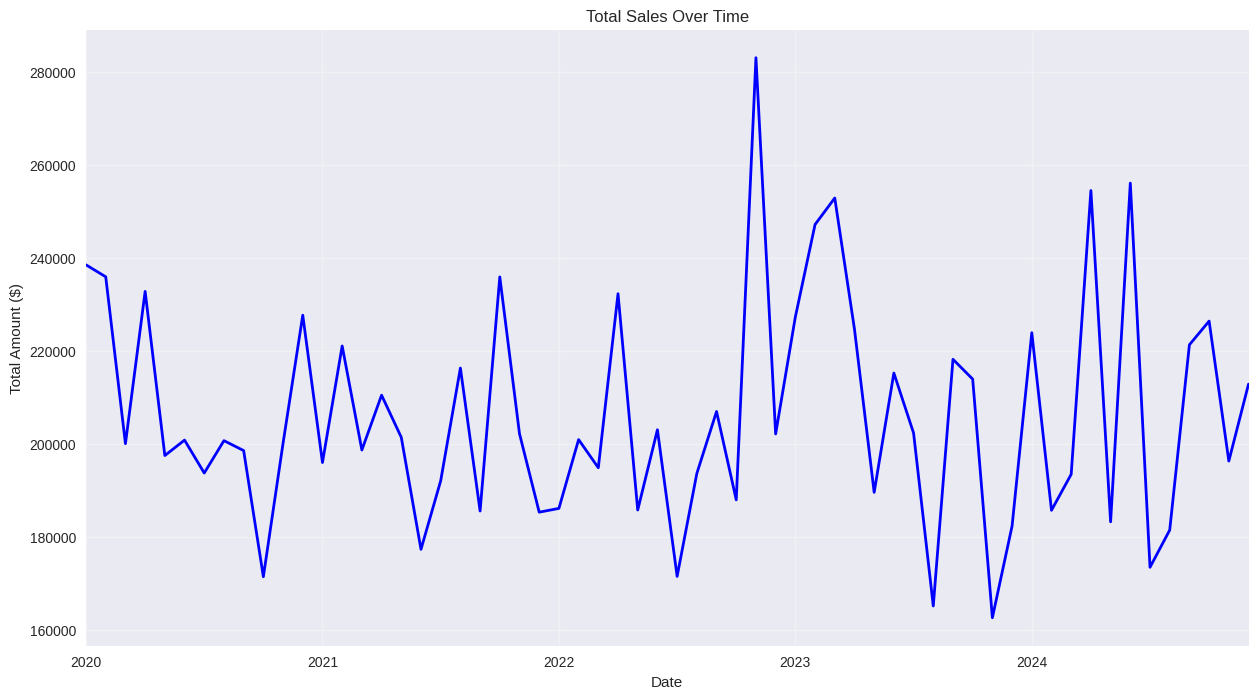

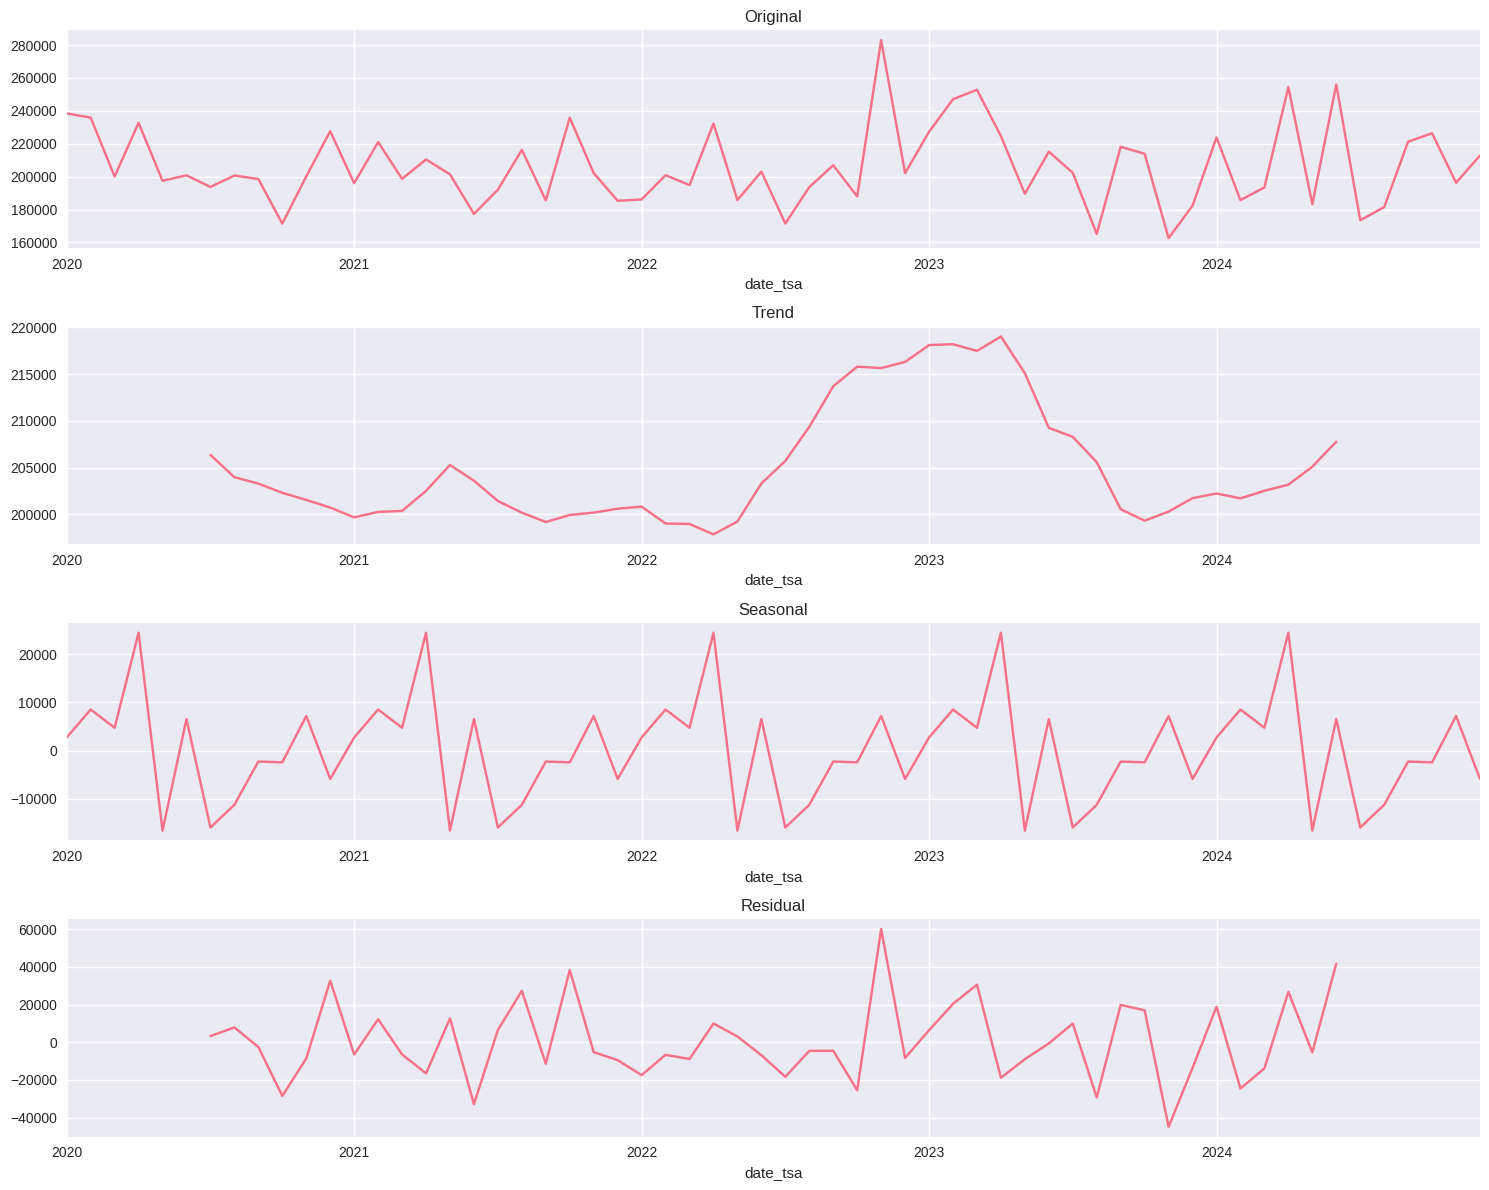

In [19]:
df['year'] = np.random.randint(2020, 2025, size=10000)
df['month'] = np.random.randint(1, 13, size=10000)

# Create a date column for time series analysis
if 'year' in df.columns and 'month' in df.columns:
    df['date_tsa'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

    # Perform time series analysis on total_amount
    if 'total_amount' in df.columns:
        print("Analyzing sales over time...")

        ts_results = analyzer.time_series_analysis(
            df, 'date_tsa', 'total_amount', freq='M'
        )

        print(f"Time series statistics:")
        print(f"  Mean: ${ts_results['mean']:.2f}")
        print(f"  Std: ${ts_results['std']:.2f}")

        if ts_results['autocorrelation']:
            print(f"  Autocorrelation (lag=1): {ts_results['autocorrelation']:.3f}")

        # Plot time series
        plt.figure(figsize=(15, 8))
        ts_results['original_series'].plot(title='Total Sales Over Time',
                                         color='blue', linewidth=2)
        plt.xlabel('Date')
        plt.ylabel('Total Amount ($)')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Plot decomposition if available
        if 'decomposition' in ts_results:
            fig, axes = plt.subplots(4, 1, figsize=(15, 12))
            ts_results['original_series'].plot(ax=axes[0], title='Original')
            ts_results['trend'].plot(ax=axes[1], title='Trend')
            ts_results['seasonal'].plot(ax=axes[2], title='Seasonal')
            ts_results['residual'].plot(ax=axes[3], title='Residual')
            plt.tight_layout()
            plt.show()

In [ ]:

# ============================================================================
# CELL 8: Customer Segmentation Analysis
# ============================================================================

print("👥 CUSTOMER SEGMENTATION ANALYSIS")
print("="*50)

# Initialize customer segmenter
segmenter = CustomerSegmenter()

# Prepare data for segmentation
segmentation_features = ['total_spent', 'avg_order_value', 'order_frequency',
                        'customer_lifetime_days', 'satisfaction_score']

# Check which features are available
available_features = [f for f in segmentation_features if f in df.columns]
print(f"📊 Using features for segmentation: {available_features}")

if len(available_features) >= 3:
    # Perform RFM analysis
    print("\n🔄 Performing RFM Analysis...")

    # Create RFM-like features if not available
    if 'recency_days' not in df.columns:
        df['recency_days'] = np.random.randint(1, 365, len(df))
    if 'total_spent' not in df.columns:
        df['total_spent'] = df['total_amount'] * np.random.uniform(1, 5, len(df))
    if 'order_frequency' not in df.columns:
        df['order_frequency'] = np.random.randint(1, 20, len(df))

    rfm_segments = segmenter.rfm_segmentation(df)

    print("✅ RFM Segmentation completed!")
    print(f"📊 Segment distribution:")
    print(rfm_segments['segments'].value_counts())

    # Perform K-means clustering
    print("\n🔄 Performing K-means clustering...")

    clustering_data = df[available_features].fillna(0)
    kmeans_result = segmenter.kmeans_segmentation(clustering_data, n_clusters=5)

    print("✅ K-means clustering completed!")
    print(f"📊 Cluster distribution:")
    cluster_counts = pd.Series(kmeans_result['labels']).value_counts().sort_index()
    print(cluster_counts)

    # Add cluster labels to dataframe
    df['cluster'] = kmeans_result['labels']
    df['rfm_segment'] = rfm_segments['segments']

    # Visualize clusters
    if len(available_features) >= 2:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        scatter = plt.scatter(df[available_features[0]],
                            df[available_features[1]],
                            c=df['cluster'], cmap='viridis', alpha=0.6)
        plt.xlabel(available_features[0])
        plt.ylabel(available_features[1])
        plt.title('K-means Clustering')
        plt.colorbar(scatter)

        plt.subplot(1, 2, 2)
        rfm_numeric = pd.Categorical(df['rfm_segment']).codes
        scatter2 = plt.scatter(df[available_features[0]],
                             df[available_features[1]],
                             c=rfm_numeric, cmap='Set3', alpha=0.6)
        plt.xlabel(available_features[0])
        plt.ylabel(available_features[1])
        plt.title('RFM Segmentation')
        plt.colorbar(scatter2)

        plt.tight_layout()
        plt.show()

# ============================================================================
# CELL 9: Machine Learning Model Training - Regression
# ============================================================================

print("🤖 MACHINE LEARNING MODEL TRAINING - REGRESSION")
print("="*50)

# Initialize ML optimizer
ml_optimizer = MachineLearningOptimizer()

# Train regression models for each numerical target
regression_targets = ['total_amount', 'profit', 'satisfaction_score', 'customer_lifetime_days']

regression_results = {}

for target in regression_targets:
    if target in df.columns:
        print(f"\n🎯 Training models for target: {target}")
        print("-" * 40)

        # Prepare data
        X_train, X_test, y_train, y_test = ml_optimizer.prepare_data(
            df, target, test_size=0.2, random_state=42
        )

        print(f"📊 Train set shape: {X_train.shape}")
        print(f"📊 Test set shape: {X_test.shape}")

        # Train regression models
        results = ml_optimizer.train_regression_models(X_train, y_train, X_test, y_test)
        regression_results[target] = results

        # Display results
        print(f"\n📈 Model Performance for {target}:")
        for model_name, metrics in results.items():
            if 'error' not in metrics:
                print(f"  {model_name}:")
                print(f"    Test R²: {metrics['test_r2']:.4f}")
                print(f"    Test MSE: {metrics['test_mse']:.4f}")

        # Find best model
        best_model = max(results.items(),
                        key=lambda x: x[1].get('test_r2', -np.inf) if 'error' not in x[1] else -np.inf)
        print(f"\n🏆 Best model for {target}: {best_model[0]} (R² = {best_model[1]['test_r2']:.4f})")

# ============================================================================
# CELL 10: Machine Learning Model Training - Classification
# ============================================================================

print("🤖 MACHINE LEARNING MODEL TRAINING - CLASSIFICATION")
print("="*50)

# Train classification models for binary targets
classification_targets = ['is_returned']

classification_results = {}

for target in classification_targets:
    if target in df.columns:
        print(f"\n🎯 Training models for target: {target}")
        print("-" * 40)

        # Prepare data
        X_train, X_test, y_train, y_test = ml_optimizer.prepare_data(
            df, target, test_size=0.2, random_state=42
        )

        print(f"📊 Train set shape: {X_train.shape}")
        print(f"📊 Test set shape: {X_test.shape}")
        print(f"📊 Class distribution: {pd.Series(y_train).value_counts().to_dict()}")

        # Train classification models
        results = ml_optimizer.train_classification_models(X_train, y_train, X_test, y_test)
        classification_results[target] = results

        # Display results
        print(f"\n📈 Model Performance for {target}:")
        for model_name, metrics in results.items():
            if 'error' not in metrics:
                print(f"  {model_name}:")
                print(f"    Test Accuracy: {metrics['test_accuracy']:.4f}")
                print(f"    F1 Score: {metrics['f1_score']:.4f}")
                if 'roc_auc' in metrics:
                    print(f"    ROC AUC: {metrics['roc_auc']:.4f}")

        # Find best model
        best_model = max(results.items(),
                        key=lambda x: x[1].get('test_accuracy', -np.inf) if 'error' not in x[1] else -np.inf)
        print(f"\n🏆 Best model for {target}: {best_model[0]} (Accuracy = {best_model[1]['test_accuracy']:.4f})")

# ============================================================================
# CELL 11: Hyperparameter Optimization
# ============================================================================

print("⚙️ HYPERPARAMETER OPTIMIZATION")
print("="*50)

# Perform hyperparameter optimization for best performing models
optimization_results = {}

# Optimize for one regression target
if 'total_amount' in df.columns:
    print("🔄 Optimizing Random Forest for total_amount prediction...")

    X_train, X_test, y_train, y_test = ml_optimizer.prepare_data(
        df, 'total_amount', test_size=0.2, random_state=42
    )

    opt_result = ml_optimizer.hyperparameter_optimization(
        X_train, y_train, model_type='random_forest', task='regression'
    )

    optimization_results['total_amount_rf'] = opt_result

    print("✅ Optimization completed!")
    print(f"🏆 Best parameters: {opt_result['best_params']}")
    print(f"📊 Best score: {opt_result['best_score']:.4f}")

# Optimize for classification target
if 'is_returned' in df.columns:
    print("\n🔄 Optimizing Random Forest for return prediction...")

    X_train, X_test, y_train, y_test = ml_optimizer.prepare_data(
        df, 'is_returned', test_size=0.2, random_state=42
    )

    opt_result = ml_optimizer.hyperparameter_optimization(
        X_train, y_train, model_type='random_forest', task='classification'
    )

    optimization_results['is_returned_rf'] = opt_result

    print("✅ Optimization completed!")
    print(f"🏆 Best parameters: {opt_result['best_params']}")
    print(f"📊 Best score: {opt_result['best_score']:.4f}")

# ============================================================================
# CELL 12: Feature Importance Analysis
# ============================================================================

print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Analyze feature importance from trained models
if hasattr(ml_optimizer, 'feature_importance') and ml_optimizer.feature_importance:

    for model_name, importance_dict in ml_optimizer.feature_importance.items():
        print(f"\n🎯 Feature Importance - {model_name}:")
        print("-" * 40)

        # Sort features by importance
        sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

        # Display top 10 features
        print("Top 10 most important features:")
        for i, (feature, importance) in enumerate(sorted_features[:10], 1):
            print(f"  {i:2d}. {feature:<30} {importance:.4f}")

        # Plot feature importance
        if len(sorted_features) > 0:
            features, importances = zip(*sorted_features[:15])

            plt.figure(figsize=(10, 8))
            y_pos = np.arange(len(features))
            plt.barh(y_pos, importances)
            plt.yticks(y_pos, features)
            plt.xlabel('Feature Importance')
            plt.title(f'Top 15 Feature Importances - {model_name}')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()

# Perform additional feature selection
print("\n🔍 ADDITIONAL FEATURE SELECTION")
print("-" * 40)

if 'total_amount' in df.columns:
    X_train, X_test, y_train, y_test = ml_optimizer.prepare_data(
        df, 'total_amount', test_size=0.2, random_state=42
    )

    # Mutual information feature selection
    selected_features = ml_optimizer.feature_selection(
        X_train, y_train, method='mutual_info', k=20
    )

    print(f"✅ Selected {selected_features.shape[1]} features using mutual information")
    print(f"📊 Selected features: {list(selected_features.columns)}")

# ============================================================================
# CELL 13: Deep Learning Models (if TensorFlow available)
# ============================================================================

print("🧠 DEEP LEARNING MODELS")
print("="*50)

# Check if TensorFlow is available
try:
    import tensorflow as tf
    from utils import DeepLearningOptimizer

    print("✅ TensorFlow available - Training deep learning models...")

    # Initialize deep learning optimizer
    dl_optimizer = DeepLearningOptimizer()

    # Train neural network for regression
    if 'total_amount' in df.columns:
        print("\n🔄 Training neural network for total_amount prediction...")

        X_train, X_test, y_train, y_test = ml_optimizer.prepare_data(
            df, 'total_amount', test_size=0.2, random_state=42
        )

        # Scale features for neural network
        X_train_scaled, X_test_scaled = ml_optimizer.scale_features(
            X_train, X_test, method='standard'
        )

        # Train neural network
        nn_results = dl_optimizer.train_neural_network(
            X_train_scaled, y_train, X_test_scaled, y_test,
            task='regression', epochs=50, batch_size=32
        )

        print("✅ Neural network training completed!")
        print(f"📊 Final test MSE: {nn_results['test_mse']:.4f}")
        print(f"📊 Final test R²: {nn_results['test_r2']:.4f}")

        # Plot training history
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(nn_results['history']['loss'], label='Training Loss')
        plt.plot(nn_results['history']['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        if 'mae' in nn_results['history']:
            plt.plot(nn_results['history']['mae'], label='Training MAE')
            plt.plot(nn_results['history']['val_mae'], label='Validation MAE')
            plt.title('Model MAE')
            plt.xlabel('Epoch')
            plt.ylabel('MAE')
            plt.legend()

        plt.tight_layout()
        plt.show()

except ImportError:
    print("❌ TensorFlow not available - Skipping deep learning models")
    print("💡 Install TensorFlow to enable deep learning features: pip install tensorflow")

# ============================================================================
# CELL 14: Sales Forecasting
# ============================================================================

print("📈 SALES FORECASTING")
print("="*50)

# Initialize sales forecaster
forecaster = SalesForecaster()

# Prepare time series data for forecasting
if 'date' in df.columns and 'total_amount' in df.columns:

    # Aggregate sales by date
    daily_sales = df.groupby('date')['total_amount'].sum().sort_index()

    print(f"📊 Time series data shape: {daily_sales.shape}")
    print(f"📊 Date range: {daily_sales.index.min()} to {daily_sales.index.max()}")

    # Simple moving average forecast
    print("\n🔄 Generating moving average forecast...")
    ma_forecast = forecaster.moving_average_forecast(daily_sales, window=3, periods=12)

    print("✅ Moving average forecast generated!")
    print(f"📊 Forecast for next 12 periods:")
    print(ma_forecast.round(2))

    # Exponential smoothing forecast
    print("\n🔄 Generating exponential smoothing forecast...")
    es_forecast = forecaster.exponential_smoothing_forecast(daily_sales, periods=12)

    print("✅ Exponential smoothing forecast generated!")
    print(f"📊 Forecast for next 12 periods:")
    print(es_forecast.round(2))

    # Plot forecasts
    plt.figure(figsize=(15, 8))

    # Plot historical data
    plt.plot(daily_sales.index, daily_sales.values, label='Historical Sales', color='blue')

    # Create future dates for plotting
    last_date = daily_sales.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='M')

    # Plot forecasts
    plt.plot(future_dates, ma_forecast, label='Moving Average Forecast',
             color='red', linestyle='--', marker='o')
    plt.plot(future_dates, es_forecast, label='Exponential Smoothing Forecast',
             color='green', linestyle='--', marker='s')

    plt.title('

In [ ]:
# ============================================================
# SECTION 4: DATA EXPLORATION & PREPROCESSING
# ============================================================

# Basic data info
print("📊 DATASET OVERVIEW")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nMissing values:")
print(df.isnull().sum().sum())

# Display basic statistics
print(f"\nDataset Info:")
print(df.info())

# Handle missing values
print("\n🔧 HANDLING MISSING VALUES")
print("=" * 50)

# Fill numerical columns with median
numerical_cols = df.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)
        print(f"Filled {col} missing values with median")

# Fill categorical columns with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)
        print(f"Filled {col} missing values with mode")

print("✅ Missing values handled")

# Additional feature engineering
print("\n⚙️ FEATURE ENGINEERING")
print("=" * 50)

# Create additional features if they don't exist
if 'revenue_per_customer' not in df.columns:
    df['revenue_per_customer'] = df.get('total_amount', 0) / (df.get('order_frequency', 1) + 1e-8)
    print("✅ Created revenue_per_customer")

if 'profit_per_unit' not in df.columns:
    df['profit_per_unit'] = df.get('profit', 0) / (df.get('quantity', 1) + 1e-8)
    print("✅ Created profit_per_unit")

# Separate features and targets
X = df[feature_columns].copy()
y = df[list(targets.keys())].copy()

print(f"\n📈 FINAL DATA SHAPE")
print(f"Features: {X.shape}")
print(f"Targets: {y.shape}")

# ============================================================
# SECTION 5: EXPLORATORY DATA ANALYSIS
# ============================================================

print("\n🔍 EXPLORATORY DATA ANALYSIS")
print("=" * 50)

# Target distributions
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Target Variables Distribution Analysis', fontsize=16, fontweight='bold')

for i, (target, target_type) in enumerate(targets.items()):
    row, col = i // 2, i % 2

    if target_type == 'regression':
        y[target].hist(bins=50, ax=axes[row, col], alpha=0.7, color=f'C{i}')
        axes[row, col].set_title(f'{target.replace("_", " ").title()} Distribution')
        axes[row, col].set_xlabel(target.replace("_", " ").title())
        axes[row, col].set_ylabel('Frequency')

        # Add statistics
        mean_val = y[target].mean()
        median_val = y[target].median()
        axes[row, col].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
        axes[row, col].axvline(median_val, color='green', linestyle='--', alpha=0.7, label=f'Median: {median_val:.2f}')
        axes[row, col].legend()
    else:
        value_counts = y[target].value_counts()
        value_counts.plot(kind='bar', ax=axes[row, col], alpha=0.7, color=f'C{i}')
        axes[row, col].set_title(f'{target.replace("_", " ").title()} Distribution')
        axes[row, col].set_xlabel('Class')
        axes[row, col].set_ylabel('Count')
        axes[row, col].tick_params(axis='x', rotation=0)

        # Add percentages
        total = value_counts.sum()
        for j, v in enumerate(value_counts.values):
            axes[row, col].text(j, v + total*0.01, f'{v/total*100:.1f}%',
                               ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Correlation analysis for top numerical features
numerical_features = X.select_dtypes(include=[np.number]).columns[:25]  # Top 25 for readability

if len(numerical_features) > 1:
    print(f"\n📊 Correlation Analysis (Top {len(numerical_features)} Numerical Features)")

    plt.figure(figsize=(15, 12))
    correlation_matrix = X[numerical_features].corr()

    # Create heatmap
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
               fmt='.2f', square=True, cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Find highly correlated features
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.8:
                high_corr_pairs.append((correlation_matrix.columns[i],
                                      correlation_matrix.columns[j],
                                      corr_val))

    if high_corr_pairs:
        print(f"\n⚠️ Highly correlated feature pairs (|r| > 0.8):")
        for feat1, feat2, corr in high_corr_pairs:
            print(f"  {feat1} <-> {feat2}: {corr:.3f}")

# ============================================================
# SECTION 6: FEATURE IMPORTANCE ANALYSIS
# ============================================================

print("\n📈 FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Analyze feature importance for each target
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Feature Importance Analysis by Target', fontsize=16, fontweight='bold')

feature_importance_results = {}

for i, (target, target_type) in enumerate(targets.items()):
    row, col = i // 2, i % 2

    print(f"Analyzing feature importance for {target}...")

    # Handle missing values in target
    mask = ~y[target].isnull()
    X_clean = X[mask]
    y_clean = y[target][mask]

    # Train a Random Forest for feature importance
    if target_type == 'regression':
        model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    else:
        model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)

    try:
        model.fit(X_clean, y_clean)

        # Get feature importance
        feature_importance = pd.DataFrame({
            'feature': X_clean.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        # Store results
        feature_importance_results[target] = feature_importance

        # Plot top 15 features
        top_features = feature_importance.head(15)
        sns.barplot(data=top_features, y='feature', x='importance', ax=axes[row, col],
                   palette='viridis')
        axes[row, col].set_title(f'Top 15 Features for {target.replace("_", " ").title()}')
        axes[row, col].set_xlabel('Importance Score')

        print(f"  ✅ Top 5 features: {', '.join(top_features['feature'].head(5).tolist())}")

    except Exception as e:
        print(f"  ❌ Error analyzing {target}: {str(e)}")
        axes[row, col].text(0.5, 0.5, f'Error analyzing\n{target}',
                           ha='center', va='center', transform=axes[row, col].transAxes)

plt.tight_layout()
plt.show()

# ============================================================
# SECTION 7: DATA PREPARATION FOR TRAINING
# ============================================================

print("\n🔧 PREPARING DATA FOR TRAINING")
print("=" * 50)

# Store all data splits and preprocessing objects
data_splits = {}
scalers = {}
feature_selectors = {}

for target, target_type in targets.items():
    print(f"\nPreparing data for {target}...")

    # Handle missing values in target
    mask = ~y[target].isnull()
    X_target = X[mask].copy()
    y_target = y[target][mask].copy()

    print(f"  Available samples: {len(X_target)}")

    # Split the data
    if target_type == 'classification' and len(y_target.unique()) > 1:
        # Stratified split for classification
        X_train, X_test, y_train, y_test = train_test_split(
            X_target, y_target, test_size=0.2, random_state=RANDOM_STATE,
            stratify=y_target
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X_target, y_target, test_size=0.2, random_state=RANDOM_STATE
        )

    print(f"  Train set: {X_train.shape}")
    print(f"  Test set: {X_test.shape}")

    # Scale features using RobustScaler (less sensitive to outliers)
    scaler = RobustScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )

    scalers[target] = scaler

    # Feature selection - select top K features
    k_features = min(50, X_train.shape[1])  # Select top 50 features or all if less

    if target_type == 'regression':
        selector = SelectKBest(f_regression, k=k_features)
    else:
        selector = SelectKBest(f_classif, k=k_features)

    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    feature_selectors[target] = selector
    selected_features = X_train_scaled.columns[selector.get_support()].tolist()

    print(f"  Selected {k_features} features")
    print(f"  Top 5 selected: {selected_features[:5]}")

    # Store everything
    data_splits[target] = {
        'X_train': X_train_selected,
        'X_test': X_test_selected,
        'y_train': y_train,
        'y_test': y_test,
        'feature_names': selected_features,
        'original_X_train': X_train,
        'original_X_test': X_test
    }

print("✅ Data preparation completed!")

# ============================================================
# SECTION 8: TRADITIONAL MACHINE LEARNING MODELS
# ============================================================

print("\n🤖 TRAINING TRADITIONAL MACHINE LEARNING MODELS")
print("=" * 50)

# Store all models and performance metrics
models = {}
performance_metrics = {}

for target, target_type in targets.items():
    print(f"\n{'='*60}")
    print(f"TRAINING MODELS FOR {target.upper()}")
    print(f"{'='*60}")

    # Get data
    X_train = data_splits[target]['X_train']
    X_test = data_splits[target]['X_test']
    y_train = data_splits[target]['y_train']
    y_test = data_splits[target]['y_test']

    print(f"Training data shape: {X_train.shape}")
    print(f"Target type: {target_type}")

    # Define models based on target type
    if target_type == 'regression':
        target_models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0, random_state=RANDOM_STATE),
            'Lasso Regression': Lasso(alpha=1.0, random_state=RANDOM_STATE, max_iter=2000),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_STATE),
            'XGBoost': xgb.XGBRegressor(random_state=RANDOM_STATE, eval_metric='rmse', verbosity=0),
            'LightGBM': lgb.LGBMRegressor(random_state=RANDOM_STATE, verbose=-1, force_col_wise=True)
        }
    else:
        target_models = {
            'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
            'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', verbosity=0),
            'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1, force_col_wise=True)
        }

    # Train each model
    target_models_trained = {}
    target_metrics = {}

    for model_name, model in target_models.items():
        print(f"\n🔄 Training {model_name}...")

        try:
            # Train the model
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)

            # Calculate metrics
            if target_type == 'regression':
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)

                metrics = {
                    'MSE': mse,
                    'RMSE': rmse,
                    'MAE': mae,
                    'R2': r2
                }

                print(f"    R² Score: {r2:.4f}")
                print(f"    RMSE: {rmse:.4f}")
                print(f"    MAE: {mae:.4f}")

            else:
                # Classification metrics
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
                recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
                f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

                # AUC for binary classification
                auc = 0
                if hasattr(model, 'predict_proba') and len(np.unique(y_test)) == 2:
                    try:
                        y_pred_proba = model.predict_proba(X_test)[:, 1]
                        auc = roc_auc_score(y_test, y_pred_proba)
                    except:
                        pass

                metrics = {
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1': f1,
                    'AUC': auc
                }

                print(f"    Accuracy: {accuracy:.4f}")
                print(f"    F1 Score: {f1:.4f}")
                if auc > 0:
                    print(f"    AUC: {auc:.4f}")

            target_models_trained[model_name] = model
            target_metrics[model_name] = metrics
            print(f"    ✅ {model_name} completed successfully!")

        except Exception as e:
            print(f"    ❌ Error training {model_name}: {str(e)}")
            continue

    # Store results
    models[target] = target_models_trained
    performance_metrics[target] = target_metrics

print("\n✅ Traditional ML models training completed!")

# ============================================================
# SECTION 9: DEEP LEARNING MODELS
# ============================================================

print("\n🧠 TRAINING DEEP LEARNING MODELS")
print("=" * 50)

for target, target_type in targets.items():
    print(f"\n{'='*40}")
    print(f"Building DL model for {target.upper()}")
    print(f"{'='*40}")

    # Get data
    X_train = data_splits[target]['X_train']
    X_test = data_splits[target]['X_test']
    y_train = data_splits[target]['y_train']
    y_test = data_splits[target]['y_test']

    input_dim = X_train.shape[1]
    print(f"Input dimension: {input_dim}")
    print(f"Training samples: {X_train.shape[0]}")

    # Build model architecture
    model = keras.Sequential([
        # Input layer with dropout
        layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Hidden layers
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
    ])

    # Output layer and compilation
    if target_type == 'regression':
        model.add(layers.Dense(1, activation='linear'))
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae', 'mse']
        )
        monitor_metric = 'val_loss'
    else:
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        monitor_metric = 'val_loss'

    print(f"Model architecture:")
    model.summary()

    # Callbacks
    early_stopping = callbacks.EarlyStopping(
        monitor=monitor_metric,
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor=monitor_metric,
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )

    # Train the model
    print(f"\n🔄 Training Deep Learning model...")

    try:
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        # Plot training history
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model Loss - {target}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        if target_type == 'regression':
            plt.subplot(1, 2, 2)
            plt.plot(history.history['mae'], label='Training MAE')
            plt.plot(history.history['val_mae'], label='Validation MAE')
            plt.title(f'Model MAE - {target}')
            plt.xlabel('Epoch')
            plt.ylabel('MAE')
            plt.legend()
            plt.grid(True)
        else:
            plt.subplot(1, 2, 2)
            plt.plot(history.history['accuracy'], label='Training Accuracy')
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
            plt.title(f'Model Accuracy - {target}')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Make predictions
        y_pred = model.predict(X_test, verbose=0).flatten()

        # Calculate metrics
        if target_type == 'regression':
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_